<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SemiSuperVisedLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from seaborn import heatmap
from sklearn.utils import class_weight

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pfad angepasst wegen neuem account!
data = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['bands']
labels = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['lulc']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])
test = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/public_test.npz')['bands']

In [5]:
# parameters

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# training iterations
ITERS = 1000

# random seed
SEED = 42

In [6]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

In [7]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

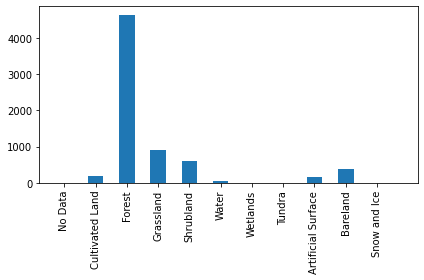

In [8]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [9]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 69.2MB 75kB/s 


In [10]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Verbose', task_type='GPU')
cbm.fit(x_train, y_train)

0:	learn: 1.6496868	total: 15.5ms	remaining: 15.5s
1:	learn: 1.4583653	total: 29.2ms	remaining: 14.6s
2:	learn: 1.3252455	total: 43.1ms	remaining: 14.3s
3:	learn: 1.2239536	total: 61.6ms	remaining: 15.3s
4:	learn: 1.1421222	total: 74.6ms	remaining: 14.8s
5:	learn: 1.0729444	total: 87.7ms	remaining: 14.5s
6:	learn: 1.0164157	total: 102ms	remaining: 14.4s
7:	learn: 0.9664633	total: 115ms	remaining: 14.3s
8:	learn: 0.9249762	total: 128ms	remaining: 14.1s
9:	learn: 0.8883772	total: 141ms	remaining: 14s
10:	learn: 0.8565333	total: 154ms	remaining: 13.9s
11:	learn: 0.8290415	total: 168ms	remaining: 13.8s
12:	learn: 0.8037524	total: 180ms	remaining: 13.7s
13:	learn: 0.7803934	total: 194ms	remaining: 13.7s
14:	learn: 0.7617464	total: 206ms	remaining: 13.5s
15:	learn: 0.7429218	total: 224ms	remaining: 13.8s
16:	learn: 0.7276830	total: 242ms	remaining: 14s
17:	learn: 0.7156945	total: 255ms	remaining: 13.9s
18:	learn: 0.7016651	total: 267ms	remaining: 13.8s
19:	learn: 0.6896628	total: 280ms	remai

In [11]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 99.22335682439235
F1-Score: [ 99.73614776  99.46351931  98.71292669  97.42310889 100.
  99.13043478 100.        ]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       190
           2       0.99      1.00      0.99      4637
           3       0.99      0.98      0.99       900
           4       1.00      0.95      0.97       616
           5       1.00      1.00      1.00        46
           8       1.00      0.98      0.99       174
           9       1.00      1.00      1.00       390

    accuracy                           0.99      6953
   macro avg       1.00      0.99      0.99      6953
weighted avg       0.99      0.99      0.99      6953



Validation

Accuracy: 83.95629672225417
F1-Score: [65.93406593 92.91274068 68.23529412 41.66666667 66.66666667 63.76811594
 75.25773196]
              precision    recall  f1-score   support

           1       0.70      0.62      0.66        48
           2       0.

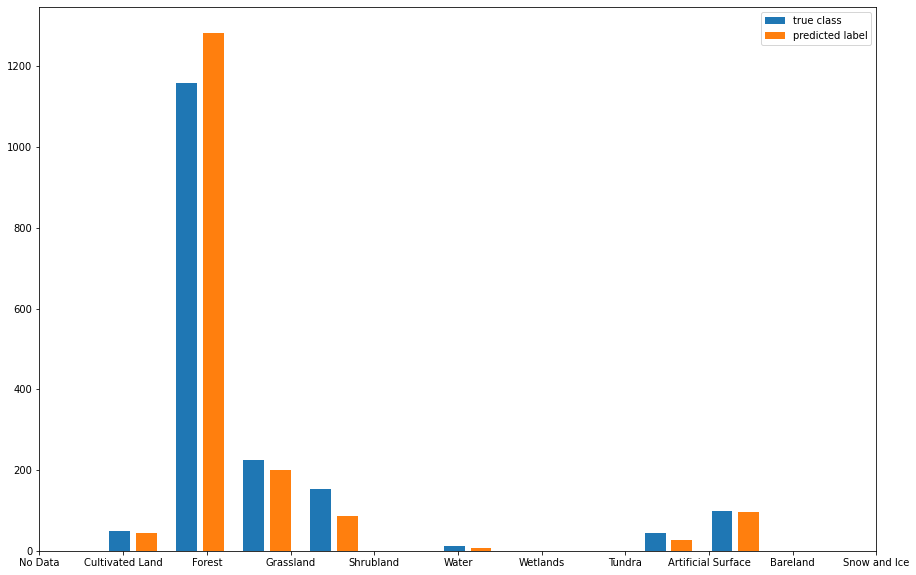

In [12]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

In [13]:
# fit the model on full unlabelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

0:	learn: 1.6427161	total: 10.1ms	remaining: 10.1s
1:	learn: 1.4540254	total: 17.9ms	remaining: 8.94s
2:	learn: 1.3259942	total: 26.2ms	remaining: 8.7s
3:	learn: 1.2227322	total: 57ms	remaining: 14.2s
4:	learn: 1.1407043	total: 64.5ms	remaining: 12.8s
5:	learn: 1.0727281	total: 72ms	remaining: 11.9s
6:	learn: 1.0147416	total: 79.4ms	remaining: 11.3s
7:	learn: 0.9656812	total: 87.3ms	remaining: 10.8s
8:	learn: 0.9239729	total: 95.6ms	remaining: 10.5s
9:	learn: 0.8889520	total: 103ms	remaining: 10.2s
10:	learn: 0.8578592	total: 115ms	remaining: 10.3s
11:	learn: 0.8299313	total: 123ms	remaining: 10.1s
12:	learn: 0.8055124	total: 130ms	remaining: 9.9s
13:	learn: 0.7823863	total: 138ms	remaining: 9.71s
14:	learn: 0.7637267	total: 146ms	remaining: 9.57s
15:	learn: 0.7465689	total: 153ms	remaining: 9.42s
16:	learn: 0.7299268	total: 161ms	remaining: 9.3s
17:	learn: 0.7161539	total: 169ms	remaining: 9.2s
18:	learn: 0.7034370	total: 181ms	remaining: 9.35s
19:	learn: 0.6922533	total: 189ms	remain

In [14]:
# predict labels for unlabelled data
transformed_data = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(transformed_data[labels == 0]).reshape(-1)
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

In [15]:
# full data
x_train, x_val, y_train, y_val = preprocess(data, new_labels)
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (8000, 72) (8000,), validation: (2000, 72) (2000,)'

In [16]:
# fit the model on full data with new labels
cbm.fit(x_train, y_train)

0:	learn: 1.6308579	total: 9.77ms	remaining: 9.76s
1:	learn: 1.4413669	total: 17.7ms	remaining: 8.85s
2:	learn: 1.3050917	total: 25.7ms	remaining: 8.55s
3:	learn: 1.2013228	total: 33.7ms	remaining: 8.4s
4:	learn: 1.1164117	total: 47.1ms	remaining: 9.38s
5:	learn: 1.0470837	total: 55ms	remaining: 9.11s
6:	learn: 0.9889670	total: 62.2ms	remaining: 8.83s
7:	learn: 0.9374951	total: 69.8ms	remaining: 8.66s
8:	learn: 0.8943646	total: 77.5ms	remaining: 8.54s
9:	learn: 0.8559698	total: 87.8ms	remaining: 8.69s
10:	learn: 0.8239839	total: 121ms	remaining: 10.8s
11:	learn: 0.7952713	total: 129ms	remaining: 10.6s
12:	learn: 0.7704535	total: 137ms	remaining: 10.4s
13:	learn: 0.7480723	total: 144ms	remaining: 10.1s
14:	learn: 0.7279153	total: 152ms	remaining: 9.96s
15:	learn: 0.7097155	total: 159ms	remaining: 9.8s
16:	learn: 0.6931602	total: 167ms	remaining: 9.66s
17:	learn: 0.6797345	total: 175ms	remaining: 9.52s
18:	learn: 0.6668645	total: 182ms	remaining: 9.39s
19:	learn: 0.6556915	total: 189ms	r

In [17]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 98.9
F1-Score: [100.          99.29750935  97.81746032  96.2787015  100.
  98.00995025 100.        ]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       195
           2       0.99      1.00      0.99      5447
           3       0.99      0.97      0.98      1015
           4       1.00      0.93      0.96       654
           5       1.00      1.00      1.00        46
           8       1.00      0.96      0.98       205
           9       1.00      1.00      1.00       438

    accuracy                           0.99      8000
   macro avg       1.00      0.98      0.99      8000
weighted avg       0.99      0.99      0.99      8000



Validation

Accuracy: 84.25
F1-Score: [49.41176471 93.12169312 68.01619433 42.63565891 80.         61.9047619
 77.67857143]
              precision    recall  f1-score   support

           1       0.57      0.44      0.49        48
           2       0.90      0.97      0.93    

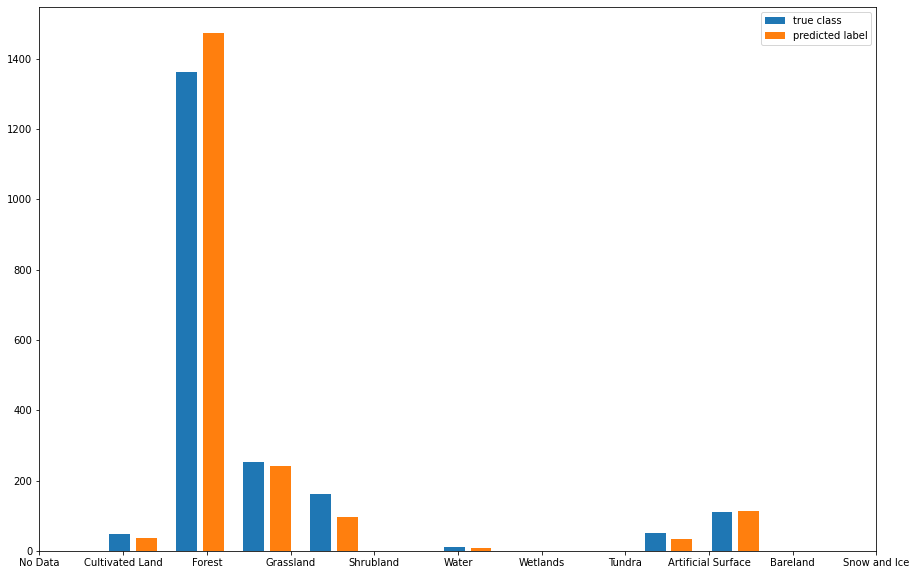

In [18]:
plt.figure(figsize=[15, 10])
plt.hist([y_val, cbm_val], width=0.25)
plt.legend(['true class', 'predicted label'])
plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


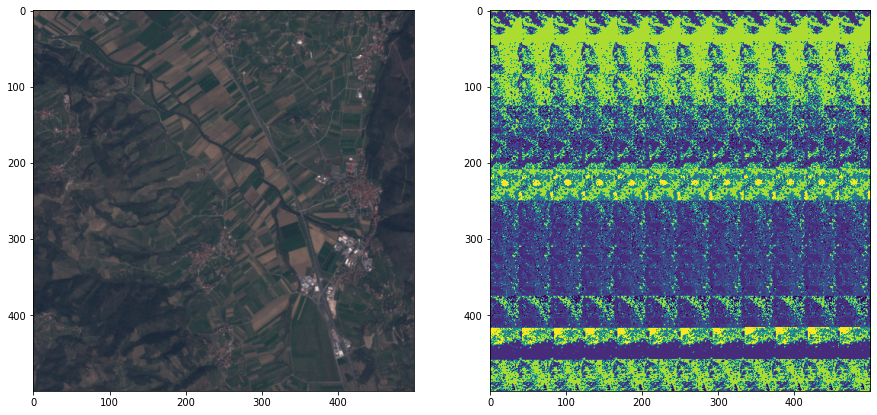

In [19]:
# plot image and predicted labels
month = 3

test_transformed = test.reshape((test.shape[1] * test.shape[2], test.shape[0] * test.shape[-1]))
pred = cbm.predict(test_transformed).reshape((500, 500))

f, (sat, lulc) = plt.subplots(1, 2, figsize=(15,15))

band = 0.5 + 2.5 * (np.flip(test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')

lulc.imshow(pred)

plt.show()